In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline

In [2]:
df = pd.read_csv('data/audio_features.csv')
df = df[df['label'].isin([0, 1, 2, 3, 4, 5, 6, 7])]
print(df.shape)
display(df.head())

# change 7 to 2
df['label'] = df['label'].map({0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 4, 7: 5})
df.head()

(7527, 10)


,wav_file,label,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic,auto_corr_max,auto_corr_std
0,Ses01F_script02_2_F000,7,0.003671,0.005739,0.004434,0.003640,0.018692,-0.008143,0.023179,0.133057
1,Ses01F_script02_2_F001,7,0.006365,0.011155,0.007913,0.007850,0.444444,-0.017120,0.094578,0.213759
6,Ses01F_script02_2_F006,0,0.039659,0.067939,0.049930,0.046050,0.345018,-0.004605,3.441704,9.317455
7,Ses01F_script02_2_F007,4,0.014478,0.026941,0.018384,0.019687,0.422764,-0.011850,0.568261,1.928247
8,Ses01F_script02_2_F008,0,0.025271,0.054958,0.031571,0.044958,0.470019,-0.005120,2.529399,9.210082


,wav_file,label,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic,auto_corr_max,auto_corr_std
0,Ses01F_script02_2_F000,5,0.003671,0.005739,0.004434,0.003640,0.018692,-0.008143,0.023179,0.133057
1,Ses01F_script02_2_F001,5,0.006365,0.011155,0.007913,0.007850,0.444444,-0.017120,0.094578,0.213759
6,Ses01F_script02_2_F006,0,0.039659,0.067939,0.049930,0.046050,0.345018,-0.004605,3.441704,9.317455
7,Ses01F_script02_2_F007,2,0.014478,0.026941,0.018384,0.019687,0.422764,-0.011850,0.568261,1.928247
8,Ses01F_script02_2_F008,0,0.025271,0.054958,0.031571,0.044958,0.470019,-0.005120,2.529399,9.210082


In [3]:
df.to_csv('data/no_sample_df.csv')

# oversample fear
fear_df = df[df['label']==3]
for i in range(30):
    df = df.append(fear_df)

sur_df = df[df['label']==4]
for i in range(10):
    df = df.append(sur_df)
    
df.to_csv('data/modified_df.csv')

In [4]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

# emotion_dict = {'ang': 0,
#                 'hap': 1,
#                 'exc': 2,
#                 'sad': 3,
#                 'fru': 4,
#                 'fea': 5,
#                 'sur': 6,
#                 'neu': 7,
#                 'xxx': 8,
#                 'oth': 8}
scalar = MinMaxScaler()
df[df.columns[2:]] = scalar.fit_transform(df[df.columns[2:]])
df.head()

,wav_file,label,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic,auto_corr_max,auto_corr_std
0,Ses01F_script02_2_F000,5,0.010847,0.013290,0.010715,0.019386,0.024313,0.168625,0.000277,0.000468
1,Ses01F_script02_2_F001,5,0.020306,0.027702,0.020774,0.042489,0.578112,0.166868,0.001141,0.000753
6,Ses01F_script02_2_F006,0,0.137206,0.178822,0.142271,0.252096,0.448783,0.169317,0.041644,0.032933
7,Ses01F_script02_2_F007,2,0.048793,0.069713,0.051051,0.107439,0.549911,0.167899,0.006873,0.006814
8,Ses01F_script02_2_F008,0,0.086686,0.144276,0.089184,0.246100,0.611379,0.169216,0.030604,0.032553


In [5]:
x_train, x_test = train_test_split(df[df.columns[1:]], test_size=0.20)

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(7837, 9)


In [6]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(df['label']).value_counts(normalize=True))
print(dict(pd.Series(df['label']).value_counts()))

del x_train['label']
del x_test['label']

(7837, 9) (1960, 9)
{0: 1103, 1: 1636, 2: 2933, 3: 1240, 4: 1177, 5: 1708}


In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())

Test Set Accuracy =  0.565
Test Set F-score =  0.568
Test Set Precision =  0.580
Test Set Recall =  0.578
Confusion matrix, without normalization
[[ 88  38  95   2   6  12]
 [ 49  55 168   0   6  47]
 [ 33  60 406   4  13  74]
 [  0   0   0 252   0   0]
 [  0   0   0   0 226   0]
 [ 16  25 198   2   5  80]]


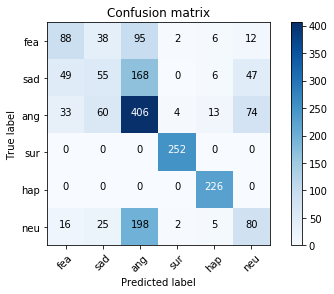

In [8]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.561
Test Set F-score =  0.567
Test Set Precision =  0.575
Test Set Recall =  0.576
Confusion matrix, without normalization
[[ 86  42  87   2   7  17]
 [ 49  63 160   0   3  50]
 [ 46  53 395   7   6  83]
 [  0   0   0 252   0   0]
 [  0   0   0   0 226   0]
 [ 22  27 194   1   5  77]]


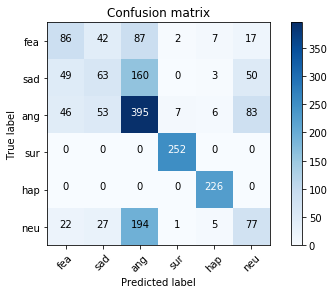

In [9]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.410
Test Set F-score =  0.361
Test Set Precision =  0.433
Test Set Recall =  0.358
Confusion matrix, without normalization
[[ 72  32 114  11   9   3]
 [ 32  43 214  11   3  22]
 [ 26  30 439  36  14  45]
 [  0   0  80 151   8  13]
 [  9  30 105  20  52  10]
 [  9  15 215  27  13  47]]


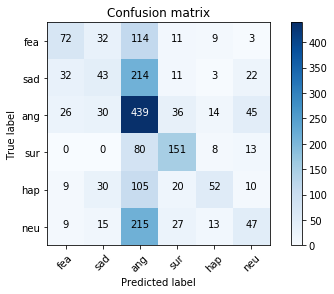

In [42]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [29]:
# Discard SVM and KNN as they weren't performing well
# svm_classifier = SVC(C=5000.0, probability=True, kernel='rbf', gamma='scale')
# svm_classifier.fit(x_train, y_train)

# # Predict
# pred_probs = svm_classifier.predict_proba(x_test)

# # Results
# display_results(y_test, pred_probs)

# with open('pred_probas/svm_classifier.pkl', 'wb') as f:
#     pickle.dump(pred_probs, f)

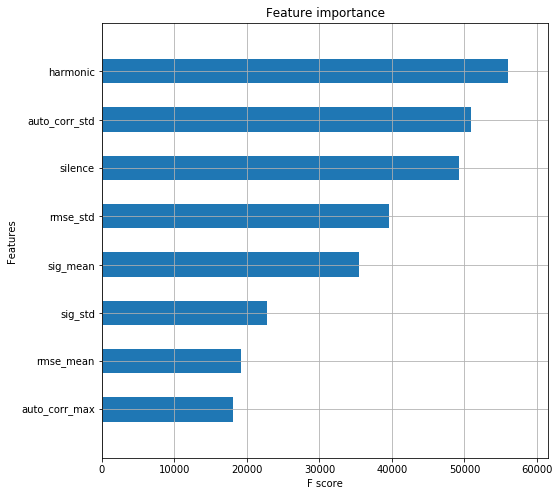

In [43]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)

In [44]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.10380024, 0.1110946 , 0.149801  , 0.14968506, 0.11192109,
       0.09556067, 0.16592902, 0.11220833], dtype=float32)

In [45]:
top_n = [3, 5, 6, 7, 8]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=1200, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)

Stats for top 3 features:
Test Set Accuracy =  0.533
Test Set F-score =  0.533
Test Set Precision =  0.538
Test Set Recall =  0.549
Stats for top 5 features:
Test Set Accuracy =  0.547
Test Set F-score =  0.558
Test Set Precision =  0.564
Test Set Recall =  0.567
Stats for top 6 features:
Test Set Accuracy =  0.549
Test Set F-score =  0.556
Test Set Precision =  0.564
Test Set Recall =  0.566
Stats for top 7 features:
Test Set Accuracy =  0.543
Test Set F-score =  0.551
Test Set Precision =  0.556
Test Set Recall =  0.560
Stats for top 8 features:
Test Set Accuracy =  0.561
Test Set F-score =  0.567
Test Set Precision =  0.575
Test Set Recall =  0.576


Test Set Accuracy =  0.566
Test Set F-score =  0.569
Test Set Precision =  0.582
Test Set Recall =  0.578
Confusion matrix, without normalization
[[ 89  37  96   3   4  12]
 [ 53  54 168   0   3  47]
 [ 36  55 413   6   7  73]
 [  0   0   0 252   0   0]
 [  0   0   0   0 226   0]
 [ 17  27 200   1   5  76]]


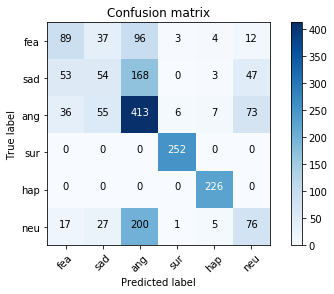

In [47]:
# Load predicted probabilities
with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/svm_classifier.pkl', 'rb') as f:
    svm_pred_probs = pickle.load(f)
    
with open('pred_probas/rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)
    
with open('pred_probas/mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)

n_samples = np.min([len(xgb_pred_probs), len(svm_pred_probs), len(rf_pred_probs), len(mlp_pred_probs)])

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs[:n_samples] + rf_pred_probs[:n_samples])/2.0
# ensemble_pred_probs = (xgb_pred_probs[:n_samples] + mlp_pred_probs[:n_samples] + rf_pred_probs[:n_samples])/3.0


# Show metrics
display_results(y_test[:n_samples], ensemble_pred_probs)